# Employee Turnover Prediction Starter Workbook

This workbook was started by the data scientist who originally worked on this project. It is organized around the following steps:
1. Import and Clean data
2. Explore data
3. Model features
4. Model data
5. Evaluate models

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Model

In [2]:
#Read in the data files
train = pd.read_csv("../Hr Analytics/data/train.csv",sep=",")
validate = pd.read_csv("../Hr Analytics/data/validate.csv",sep=",")
test = pd.read_csv("../Hr Analytics/data/test.csv",sep=",")

In [3]:
#Examine the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3087 entries, 0 to 3086
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        3087 non-null   int64  
 1   Attrition                         3087 non-null   int64  
 2   Age                               3087 non-null   int64  
 3   DistanceFromHome                  3087 non-null   int64  
 4   MonthlyIncome                     3087 non-null   int64  
 5   NumCompaniesWorked                3087 non-null   float64
 6   PercentSalaryHike                 3087 non-null   int64  
 7   TotalWorkingYears                 3087 non-null   float64
 8   TrainingTimesLastYear             3087 non-null   int64  
 9   YearsAtCompany                    3087 non-null   int64  
 10  YearsSinceLastPromotion           3087 non-null   int64  
 11  YearsWithCurrManager              3087 non-null   int64  
 12  Perfor

In [4]:
#Let's view some of the sample data
pd.set_option("display.max_columns", None)
train.head()

,Unnamed: 0,Attrition,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobInvolvement,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked_Missing,TotalWorkngYears_Missing,EnvironmentSatisfaction_Missing,JobSatisfaction_Missing,WorkLifeBalance_Missing,Age_Bin,Gender_Male,JobRole_Human_Resources,JobRole_Laboratory _Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Education_2,Education_3,Education_4,Education_5,EducationField_Life_Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical_Degree,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,MaritalStatus_Married,MaritalStatus_Single,Department_Research_Development,Department_Sales,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3
0,1289,0,32,6,24720,7.0,13,10.0,2,7,0,7,3,2,4.0,2.0,3.0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0
1,2589,0,39,21,30670,1.0,20,21.0,5,21,1,6,4,3,2.0,4.0,4.0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
2,2132,0,28,23,68520,1.0,18,1.0,2,1,0,0,3,4,4.0,2.0,3.0,1,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
3,1221,0,31,6,24370,9.0,14,9.0,3,2,2,2,3,3,3.0,4.0,4.0,1,1,1,1,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
4,2823,0,36,2,79180,2.0,12,8.0,3,6,0,1,3,4,3.0,4.0,3.0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


In [5]:
#Drop an extraneous column and determine the shape of the train data frame.
train=train.drop(['Unnamed: 0'], axis=1)
test=test.drop(['Unnamed: 0'], axis=1)
validate=validate.drop(['Unnamed: 0'], axis=1)
train.shape

(3087, 53)

#### Design Note 1.1

The data were explored, cleaned, and prepared for analysis in the notebook 1_employee_turn_data_prep.ipynb. This notebook contains a start to the model building process. We wil explore a basic model and some discussion of performance metrics. There are several Python packages that can be used to create a logistic regression model, and two of the more popular is scikit-learn and statsmodel. Scikit-learn is a machine learning package, whereas statsmodel falls more within the statistical tradition. Statsmodel provides some useful statistical output (```p-values```, ```coeff```, ```intervals```). Scikit-learn provides good fit metrics (```precision```, ```recall```, ```confusion matrix```) and fits within a machine learning model. Given that we want to do both explanatory and predictive modeling, we will use statsmodel in this file to create our model, which offers some nice statistical output, but we also will leverage some of scikit-learn and its fit metrics. For this initial exploratory modeling, we will use statsmodels for the primary modeling and statistical evaluation, but we will also lean heavily on many of the advanced fit metrics that scikit-learn provides.

In [6]:
def apply_prediction_formula(log_prob):
    return (1/(1+np.exp(-log_prob)))

In [89]:
def predict_initiative_impact(data,target_var,chg_in_target_var,log_reg,risk_threshold=.25):
    df = data.loc[data['Attrition'] == 0]
    val_df = data.loc[data['Attrition'] == 0,list(log_reg.params.index)[1:]]
    intercept = log_reg.params[0]
    coefs = list(log_reg.params[1:])
    
    low_ci_coefs = list(log_reg.conf_int()[0][1:])
    low_ci_intercept = log_reg.conf_int()[0][0]
    
    upp_ci_coefs = list(log_reg.conf_int()[1][1:])
    upp_ci_intercept = log_reg.conf_int()[1][0]
    
    # baseline
    vals = val_df.to_numpy()
    log_prob = np.add(np.matmul(vals,coefs),intercept)
    prob = list(map(apply_prediction_formula,log_prob))
    df['ProbAttrition'] = prob
    pre_initiative_risk = df.loc[df.ProbAttrition >= risk_threshold].shape[0]
#     pre_initiative_risk = df.ProbAttrition.sum()
    
    # confidence interval
    log_prob = np.add(np.matmul(vals,low_ci_coefs),low_ci_intercept)
    prob = list(map(apply_prediction_formula,log_prob))
    df['ProbAttritionLowCI'] = prob
    pre_initiative_risk_low = df.loc[df.ProbAttritionLowCI >= risk_threshold].shape[0]
    
    log_prob = np.add(np.matmul(vals,upp_ci_coefs),upp_ci_intercept)
    prob = list(map(apply_prediction_formula,log_prob))
    df['ProbAttritionUppCI'] = prob
    pre_initiative_risk_upp = df.loc[df.ProbAttritionUppCI >= risk_threshold].shape[0]
    df_pre_initiative = df.copy()
    
    # initiative
    val_df[target_var] = val_df[target_var].add(chg_in_target_var)
    vals = val_df.to_numpy()    
    log_prob = np.add(np.matmul(vals,coefs),intercept)
    prob = list(map(apply_prediction_formula,log_prob))
    df['ProbAttrition'] = prob
    post_initiative_risk = df.loc[df.ProbAttrition >= risk_threshold].shape[0]
#     post_initiative_risk = df.ProbAttrition.sum()
    
    log_prob = np.add(np.matmul(vals,low_ci_coefs),low_ci_intercept)
    prob = list(map(apply_prediction_formula,log_prob))
    df['ProbAttritionLowCI'] = prob
    post_initiative_risk_low = df.loc[df.ProbAttritionLowCI >= risk_threshold].shape[0]
    
    log_prob = np.add(np.matmul(vals,upp_ci_coefs),upp_ci_intercept)
    prob = list(map(apply_prediction_formula,log_prob))
    df['ProbAttritionUppCI'] = prob
    post_initiative_risk_upp = df.loc[df.ProbAttritionUppCI >= risk_threshold].shape[0]
    
    return df_pre_initiative,df,pre_initiative_risk_low,pre_initiative_risk,pre_initiative_risk_upp,post_initiative_risk_low,post_initiative_risk,post_initiative_risk_upp
    

In [8]:
# First, we setup a baseline model using statsmodel. We can use the logit model in statsmodel and our training data set
# to create a basic model. Attrition is our y-variable. We'll include a few predictors that seem to have
# potential as predictors.
# For those familiar with the r-programming lanugage, the syntax of statsmodels should feel familiar.

resp_var = 'Attrition'
pred_vars = ['WorkLifeBalance','PercentSalaryHike','JobSatisfaction','EnvironmentSatisfaction','DistanceFromHome',
            'MonthlyIncome','TrainingTimesLastYear']

logit_phrase = resp_var + ' ~ ' + ' + '.join(pred_vars)

log_reg = sm.logit(logit_phrase, data=train).fit()

Optimization terminated successfully.
         Current function value: 0.183554
         Iterations 8


In [9]:
data = pd.read_csv("../Hr Analytics/data/data_cleaned.csv")

In [88]:
initiatives = {
    'Pay base increase':['MonthlyIncome',7500],
    'Training':['TrainingTimesLastYear',0.5],
    'Workplace flexibility':['WorkLifeBalance',0.3],
    'Limit business travel':['EnvironmentSatisfaction',0.75],
    'Employee Appreciation':['JobSatisfaction',0.5]
}

vals =[]
for i in initiatives.keys():
    df_pre_initiative,df,lpre,pre,upre,lpost,post,upost = predict_initiative_impact(data,initiatives[i][0],initiatives[i][1],log_reg,.5)
    vals.append([i,'Pre-Implementation',pre])
    vals.append([i,'Post-Implementation',post])
    print('{}: Before L:{} - {} - U:{} | After L:{} - {} - U:{} | Savings: {}'.format(i,lpre,pre,upre,lpost,post,upost,(pre-post)*3000))
    
df1 = pd.DataFrame(vals,columns=['Initiative','Stage of Initiative','Employees at Risk of Attritting'])

Pay base increase: Before L:1 - 234.14127762191686 - U:1855 | After L:1 - 230.66405283070907 - U:1857 | Savings: 10431.674373623366
Training: Before L:1 - 234.14127762191686 - U:1855 | After L:0 - 226.10284030332883 - U:1861 | Savings: 24115.31195576407
Workplace flexibility: Before L:1 - 234.14127762191686 - U:1855 | After L:0 - 163.93977287117795 - U:1504 | Savings: 210604.51425221673
Limit business travel: Before L:1 - 234.14127762191686 - U:1855 | After L:0 - 168.5360320562058 - U:1559 | Savings: 196815.73669713314
Employee Appreciation: Before L:1 - 234.14127762191686 - U:1855 | After L:0 - 176.65923297291832 - U:1588 | Savings: 172446.13394699563


In [11]:
df1

,Initiative,Stage of Initiative,Employees at Risk of Attritting
0,Pay base increase,Pre-Implementation,88
1,Pay base increase,Post-Implementation,87
2,Training,Pre-Implementation,88
3,Training,Post-Implementation,82
4,Workplace flexibility,Pre-Implementation,88
5,Workplace flexibility,Post-Implementation,50
6,Limit business travel,Pre-Implementation,88
7,Limit business travel,Post-Implementation,52
8,Employee Appreciation,Pre-Implementation,88
9,Employee Appreciation,Post-Implementation,57


In [12]:
data.loc[data.Attrition==0,'MonthlyIncome'].mean()

65672.59529602596

In [13]:
df

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobInvolvement,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,NumCompaniesWorked_Missing,TotalWorkngYears_Missing,EnvironmentSatisfaction_Missing,JobSatisfaction_Missing,WorkLifeBalance_Missing,ProbAttrition,ProbAttritionLowCI,ProbAttritionUppCI
0,0,51,Travel_Rarely,Sales,5,2,Life_Sciences,Female,1,Healthcare_Representative,Married,131160,1.0,11,0,1.000000,6,1,0,0,1,3,3.0,4.0,3.0,1,1,1,1,1,0.018455,0.000149,0.703040
1,0,32,Travel_Frequently,Research_Development,14,4,Other,Male,4,Sales_Executive,Married,193280,1.0,15,3,5.000000,2,5,0,3,3,2,3.0,2.0,2.0,1,1,1,1,1,0.187155,0.002712,0.951202
2,0,38,Non-Travel,Research_Development,2,5,Life_Sciences,Male,3,Human_Resources,Married,83210,3.0,11,3,13.000000,5,8,7,5,3,4,2.0,2.0,4.0,1,1,1,1,1,0.033447,0.000509,0.701501
3,0,32,Travel_Rarely,Research_Development,8,1,Medical,Male,1,Sales_Executive,Single,23420,4.0,12,2,9.000000,2,6,0,4,1,3,4.0,4.0,3.0,1,1,1,1,1,0.016500,0.000244,0.535417
4,0,46,Travel_Rarely,Research_Development,6,3,Life_Sciences,Female,4,Research_Director,Married,40710,3.0,13,0,28.000000,5,7,7,7,3,3,4.0,3.0,2.0,1,1,1,1,1,0.078604,0.001134,0.865016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3694,0,42,Travel_Rarely,Research_Development,4,4,Medical,Female,1,Research_Scientist,Single,60290,3.0,20,1,10.000000,5,3,0,2,3,3,3.0,3.0,2.0,1,1,1,1,1,0.008069,0.000084,0.439672
3695,0,29,Travel_Rarely,Research_Development,2,4,Medical,Male,1,Laboratory _Technician,Divorced,26790,2.0,14,0,10.000000,2,3,0,2,3,4,4.0,4.0,2.0,1,1,1,1,1,0.027412,0.000501,0.613319
3696,0,25,Travel_Rarely,Research_Development,20,2,Life_Sciences,Male,2,Sales_Executive,Married,37020,0.0,12,0,5.000000,4,4,1,2,4,3,1.0,4.0,3.0,1,1,1,1,1,0.153339,0.002362,0.932692
3697,0,42,Travel_Rarely,Sales,14,2,Medical,Male,1,Laboratory _Technician,Divorced,23980,0.0,16,1,10.000000,2,9,7,8,3,4,4.0,4.0,1.0,1,1,1,1,1,0.127736,0.002240,0.905241


In [114]:
df_pre_initiative,df,lpre,pre,upre,lpost,post,upost = predict_initiative_impact(data,'JobSatisfaction',.5,log_reg,.5)

var = 'BusinessTravel'
df_travel = df_pre_initiative.loc[df_pre_initiative.ProbAttrition > .5,[var,'Attrition']].groupby([var]).count() / df_pre_initiative.loc[df_pre_initiative.ProbAttrition > .5,[var,'Attrition']].shape[0]# .rename(
#     columns={'Attrition':'Travel Type'})

In [115]:
df_travel

,Attrition
BusinessTravel,
Non-Travel,0.056818
Travel_Frequently,0.181818
Travel_Rarely,0.761364


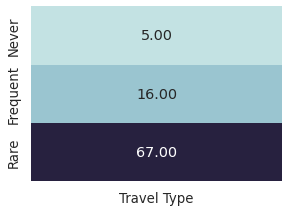

In [104]:
fig = plt.figure()
    
labels = ['Never','Frequent','Rare']
ax = sns.heatmap(df_travel,cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),annot=True,fmt='.2f',cbar=False,yticklabels = labels)
ax.get_yaxis().set_label_text('')
plt.tight_layout()
fig.set_size_inches(4,3,forward=True)
fig.savefig('temp.png', transparent=True,)

In [15]:
df_pre_initiative.ProbAttrition.sum()

234.14127762191686

In [16]:
df.ProbAttrition.sum()

176.65923297291832

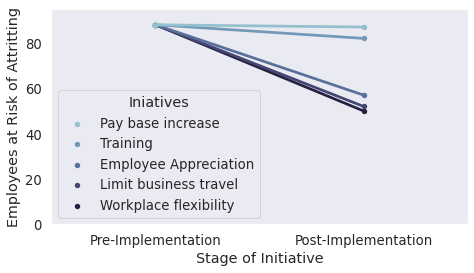

In [86]:
sns.set(font = 'sans-serif',font_scale = 1.2)
sns.set_style('dark')
fig = plt.figure()

order = df1.loc[df1['Stage of Initiative'] == 'Post-Implementation',
               ['Initiative','Employees at Risk of Attritting']].sort_values('Employees at Risk of Attritting')
ax = sns.pointplot(x='Stage of Initiative',y='Employees at Risk of Attritting',hue='Initiative',
              data=df1,markers='.',palette=sns.color_palette("ch:start=.2,rot=-.3_r"),hue_order=list(order['Initiative']))

# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
order = [4,3,2,1,0]
handles, labels = plt.gca().get_legend_handles_labels()
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='best',
           shadow=False,facecolor='inherit',title='Iniatives')
ax.set_ylim(0, 95)
plt.tight_layout()

fig.set_size_inches(7,4,forward=True)
fig.savefig('temp.png', transparent=True)

#### Design Note 1.2: Statistical Evaluation of the Model

One advantage of statsmodel is that it offers robust statistical reporting on models. By printing the ```summary()``` of the log, we can view some key aspects of model performance.

```Pseudo R-squ.```: In conventional linear regression, one metric of quality is R2, which represents the proportion of the variance in the dependent variable that is explained by the model. An R2 of 40% suggests that 40% of the variation of the dependent variable is explained by the independent variables. Because logistic regression does not utilize ordinary-least squares for fitting a model, it is not calculated to minimize variance, so R2 as a goodness-of-fit metric does not translate. Instead, we must use a psuedo-R2. Psuedo-R2 looks like traditional R2 in that it also ranges from 0 to 1, but it does not have the same intuition as R2. Psuedo-R2 is a relative metric that can be used to compare models on the same set of data.

```coef```: The coef. column contains the coefficient for each variable in the model. This helps us in model interpretation. If this were linear regression, we know that a 1 unit change in the x-variable would produce a ```coef``` change in the y-variable. For example, if we are modeling home size (sq ft) vs. home price ($), the coef would tell us that a 1 sq ft increase in size will impact home price by ```coef``` dollars. The intuition works differently in logistic regression. Because the exponents are expressed in log-odds, we have to exponentiate them to interpret them. Doing so will tell us how the odds change give the coefficient.

```P>|z|```: This column shows which variables are statistically significant. Anything below 0.05 would traditionally be considered statistically significant. Statistical significance is not the end-all-be-all. It can help in manually building explanatory models, informing variable inclusion decisions. For machine learning, we may well include non-statistically significant variables to improve predictive utility. Better metrics to judge if it is worth including a variable in model are those that consider model complexity vs. performance, such as AIC and BIC.

```[0.025  0.975]```: These columns provide a confidence interval around the coefficients, so we can consider uncertainty in our analysis. 

In [24]:
#Now that we fit a baseline model, we can examine some of the output to understand the results.
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 3087
Model:                          Logit   Df Residuals:                     3079
Method:                           MLE   Df Model:                            7
Date:                Mon, 15 Aug 2022   Pseudo R-squ.:                  0.5634
Time:                        23:19:35   Log-Likelihood:                -566.63
converged:                       True   LL-Null:                       -1297.9
Covariance Type:            nonrobust   LLR p-value:                1.184e-311
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  11.7434      0.632     18.570      0.000      10.504      12.983
WorkLifeBalance            -1.6982      0.099    -17.224      0.000      -1.891      -1.505


In [25]:
# Another way to veiw the model coefficients
print(log_reg.params)

Intercept                  11.743413
WorkLifeBalance            -1.698220
PercentSalaryHike          -0.399605
JobSatisfaction            -0.810643
EnvironmentSatisfaction    -0.628109
DistanceFromHome            0.061715
MonthlyIncome              -0.000003
TrainingTimesLastYear      -0.102873
dtype: float64


#### Design Note 1.3: Exponentiating coefficients

As mentioned previously, logisitic regression coefficients are expressed in log-odds. In order to interpret them as odds-ratios, we have exponentiate them. Mathematically, if we take the mathematical constant e and raise it to the power of our coefficient, we will convert our values from log-odds to odds (e^[ln(OR)]). Recall that odds ratio represents a ratio of probabilities: if there is an 80% chance of winning a soccer (football) match and a 20% of losing it, then the odds ratio of winning is 0.8/0.2 or 4:1 (four-to-one). If the odds of an event are even (0.5, 0.5), then the odds ratio is 0.5/0.5 = 1 (or 1:1). See the course logistic regression overview for more discussion on coefficient interpretation: https://docs.google.com/document/d/1VM_JxZ64zoGGg6aAICJBPW_fnRtKIBHodubKo4eBAaI/edit?usp=sharing


In [26]:
# Build a data frame with odds ratios and their confidence intervals.
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    }
)
# Exponentiate the data frame
odds_ratios = np.exp(odds_ratios)

# Print the results
print(odds_ratios)

                                    OR      Lower CI       Upper CI
Intercept                125921.420314  36460.052351  434892.521305
WorkLifeBalance               0.183009      0.150851       0.222022
PercentSalaryHike             0.670585      0.636277       0.706743
JobSatisfaction               0.444572      0.379335       0.521029
EnvironmentSatisfaction       0.533600      0.462129       0.616124
DistanceFromHome              1.063659      1.042114       1.085650
MonthlyIncome                 0.999997      0.999994       1.000000
TrainingTimesLastYear         0.902242      0.797459       1.020793


In [27]:
odds_ratios.columns

Index(['OR', 'Lower CI', 'Upper CI'], dtype='object')

In [42]:
df2

,OR,actual_or
WorkLifeBalance,0.183009,-0.816991
PercentSalaryHike,0.670585,-0.329415
JobSatisfaction,0.444572,-0.555428
EnvironmentSatisfaction,0.533600,-0.466400
DistanceFromHome,1.063659,0.063659
MonthlyIncome,0.999997,-0.000003
TrainingTimesLastYear,0.902242,-0.097758


In [43]:
df2 = odds_ratios[['OR']].loc[odds_ratios.index != 'Intercept'].copy()
df2['actual_or'] = 0
df2.loc[df2.OR < 1,'actual_or'] =  df2.loc[df2.OR < 1,'OR'] - 1
df2.loc[df2.OR >= 1,'actual_or'] =  df2.loc[df2.OR >= 1,'OR'] - 1

mins = list(data[list(df2.index)].min())
mins[-1] = 1
mins[-2] = 1000
mins


df2['mins'] = mins
df2['chg_attrition'] = df2.actual_or * df2.mins
df2.sort_values('chg_attrition',ascending=True)

df3 = df2[['OR']].sort_values('OR',ascending=False).rename(columns={'OR':'Odds Ratio'})
# df3['abs'] = abs(df3['Impact on Attrition'])
# df3 = df3.sort_values('Impact on Attrition',ascending=True)[['Impact on Attrition']]
df3

,Odds Ratio
DistanceFromHome,1.063659
MonthlyIncome,0.999997
TrainingTimesLastYear,0.902242
PercentSalaryHike,0.670585
EnvironmentSatisfaction,0.533600
JobSatisfaction,0.444572
WorkLifeBalance,0.183009


In [44]:
df2

,OR,actual_or,mins,chg_attrition
WorkLifeBalance,0.183009,-0.816991,1.0,-0.816991
PercentSalaryHike,0.670585,-0.329415,1.0,-0.329415
JobSatisfaction,0.444572,-0.555428,1.0,-0.555428
EnvironmentSatisfaction,0.533600,-0.466400,1.0,-0.466400
DistanceFromHome,1.063659,0.063659,1.0,0.063659
MonthlyIncome,0.999997,-0.000003,1000.0,-0.002943
TrainingTimesLastYear,0.902242,-0.097758,1.0,-0.097758


In [45]:
df2['1_percent_change'] = -.1 / df2['actual_or']
df2 = df2[["1_percent_change"]].rename(columns={"1_percent_change":'Adjustment'})

<AxesSubplot:>

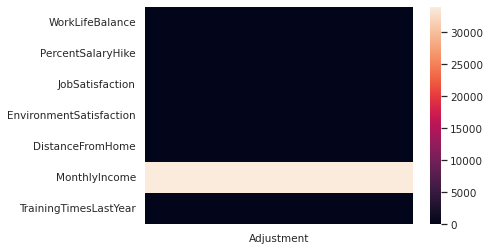

In [46]:
sns.heatmap(df2,cmap=None)

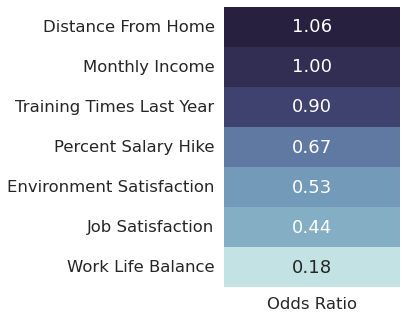

In [47]:
import re
var_names = []
for x in df3.index:
    var_names.append(' '.join(re.findall('[A-Z][^A-Z]*', x)))
sns.set(font = 'sans-serif',font_scale = 1.5)
    
fig = plt.figure()
    
sns.heatmap(df3,cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),annot=True,fmt='.2f',cbar=False,yticklabels = var_names)
plt.tight_layout()
fig.set_size_inches(6,5,forward=True)
fig.savefig('temp.png', transparent=True,)

In [48]:
data.TrainingTimesLastYear.unique()

array([6, 2, 5, 3, 4, 0, 1])

In [49]:
for x in df_cor.index:
    var_names.append(' '.join(re.findall('[A-Z][^A-Z]*', x)))
    
df_cor['Metric'] = var_names

NameError: name 'df_cor' is not defined

#### Design Note 1.4: Confusion Matrices

One of the standard classification quality tools is the confusion matrix. A confusion matrix can be used in multinomial situations, but in binary classification, the confusion matrix allows the data scientist to measure four classification scenarios from the model: true positive, true negative, false positive, and false negative. The definitions of the metrics are found below:

```true positive (TP)```: A true positive is when the model predicts a positive-state outcome for the dependent variable and the ground truth is also positive. For example, if we were predicting if someone has diabetes given their blood levels, a true positive result would be that our model predicts the person has diabates and they actually do. (Note that 'positive' means we predict something happens, and it does not necessary that the outcome is good).

```true negative (TN)```: A true negative is when the model predicts a negative-state outcome for the dependent variable and the ground truth is also negative. For example, if we were predicting if someon has diabetes given their blood levels, a true negative result would be that the model predicts the person does not have diabetes and they do not in reality. (Note that 'negative' means we predict something does not happen, and it does not necessary mean that the outcome is good).

A perfect model will categorize all events as either true positives or true negatives. This is highly unlikely in most modeling situations, so we must learn about classification error: false positives and false negatives. 

```false positive (FP)```: A false positive is when the model predicts a positive-state outcome for the dependent variable and the ground truth is actually negative. Using our diabetes example, a false positive occurs when the model says someone has diabetes but in reality they do not. A false positive is a category of classification error.

```false negative (FN)```: A false negative is when the model predicts a negative-state outcome for the dependent variable and the ground truth is actually positive. Using our diabetes example, a false negative occurs when the model says someone does not have diabetes but in reality they do. A false negative is a category of classification error. 


```confusion matrix```: A confusion matrix consists of two axes that define four squares. Each square provides the raw count for a specific classification metric (TP, TN, FP, FN).The key to identifying which square is associated with which classification metric is knowing if the actual (ground truth) results are the rows or the columns.

For ```statsmodels```, we use a method called pred_table() to generate a confusion matrix (though you can also use sklearn's confusion matrix tools on non-sklearn models). According to the statsmodel documentation, "pred_table[i,j] refers to the number of times “i” was observed and the model predicted “j”. Correct predictions are along the diagonal." So the confusion matrix in statsmodels, the rows represent the actual (observed) classification and the columns represent the predicted. The diagonal from upper left to lower right are the true positives and true negatives. 


In [50]:
# Create a confusion matrix for our initial model on the training data set
log_reg.pred_table()

array([[2566.,   62.],
       [ 156.,  303.]])

While ```statsmodels``` can provide a basic confusion matrix, ```scikit-learn``` offers much more in the way of classification metrics. Also, the confusion matrix above using our training data. Of course, if we were to evaluate modeling just on training data, we might easily find our way into overfitting. Below provides the necessary code snippets to (1) generate predictions on our test data set (how effective is our training model at predicting values that are out-of-sample?) and (2) create a basic confusion matrix as well as a more graphical representation.

In [51]:
y_pred = log_reg.predict(validate)
prediction = list(map(round, y_pred))

# Now that we have done the legwork, we can produce the desired confusion matrices.

# Create a sklearn confusion matrix
cm = confusion_matrix(validate['Attrition'], prediction)
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(validate['Attrition'], prediction))

Confusion Matrix : 
 [[518  13]
 [ 35  95]]
Test accuracy =  0.9273827534039334


In [52]:
# Building a confusion matrix on the test dataset

y_pred = log_reg.predict(validate)

# Y-pred are the probabilities that each row (employee) in the test set will attrite. 
# To produce a confusion matrix work we need to change that those probabilities to binary (0,1) values. 
# This can be done by rounding the y_pred values
prediction = list(map(round, y_pred))
 

Before we populate the confusion matrix, a helpful exercise is to examine the probabilities we have produce for our test data set. In this context, these values represent the probability that individuals in the test data set will attrite.

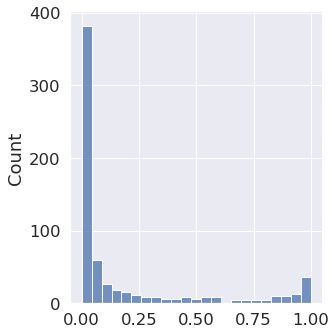

In [53]:
sns.displot(y_pred, kde=False, rug=False)

In [54]:
# Now that we have done the legwork, we can produce the desired confusion matrices.

# Create a sklearn confusion matrix
cm = confusion_matrix(validate['Attrition'], prediction)
print ("Confusion Matrix : \n", cm)

# We also can use sklearn to calculate the overall accuracy of the model.  A flawed, but helpful metric.
print('Test accuracy = ', accuracy_score(validate['Attrition'], prediction))

Confusion Matrix : 
 [[518  13]
 [ 35  95]]
Test accuracy =  0.9273827534039334


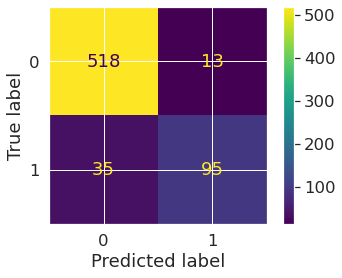

In [55]:
# Should we want a slightly more graphical display, sklearn also offers ConfusionMatrixDisplay()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [56]:
df_cm = pd.DataFrame(cm,columns=['Predicted to Stay','Predicted to Leave'],index=['Actually Stayed','Actually Left'])

In [57]:
df_cm.to_numpy()

array([[518,  13],
       [ 35,  95]])

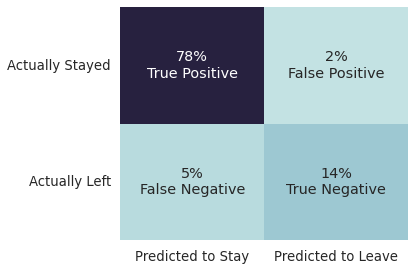

In [119]:
# sns.heatmap(df_cm,cmap=sns.diverging_palette(0, 196,l=71,s=85,as_cmap=True),annot=True,fmt='.0f')
a_cm = df_cm.to_numpy()
labels = [['{:.0%}\nTrue Positive'.format(a_cm[0][0]/a_cm.sum()),
           '{:.0%}\nFalse Positive'.format(a_cm[0][1]/a_cm.sum())],
          ['{:.0%}\nFalse Negative'.format(a_cm[1][0]/a_cm.sum()),
           '{:.0%}\nTrue Negative'.format(a_cm[1][1]/a_cm.sum())]]

fig = plt.figure()
sns.heatmap(df_cm,cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),annot=labels,fmt='',cbar=False)

# ax.get_yaxis().set_label_text('')
plt.yticks(rotation=0) 

plt.tight_layout()

# fig.set_size_inches(7,4,forward=True)
fig.savefig('temp.png', transparent=True)



In [59]:
a_cm.sum()

661

#### Design Note 1.5: Fit metrics

As mentioned previously, the popular machine learning package ```scikit-learn``` can model several forms of regression, including logistical regression. Generally, its reporting on the statistical properities of models is not as robust as ```statsmodels```, but its fit metrics are superior. Specifically, ```scikit-learn``` provides built-in reporting for several key classification algorithms including precision, recall, F1, and AUC. We will use this metrics to better understand the complexities of our model performance. Below are some basic definitions for some of the fit metrics. For a more detailed discussion, refer to the course logistic regression guide: https://docs.google.com/document/d/1VM_JxZ64zoGGg6aAICJBPW_fnRtKIBHodubKo4eBAaI/edit?usp=sharing

Recall: A measure of a classifiers completeness
How many relevant items are selected? 
Recall: TP / Real Positive
A model that produces no false positives has a precision of 1.0.

Precision: A measure of a classifiers exactness.
How many selected items are relevant?
Precision: TP / Predicted Positive
A model that produces no false negatives has a recall of 1.0.

F1-score:  the harmonic mean of precision and recall.

Sklearn provides a helpful classification report to provide a view into precision, recall, and f1-score. It provides these values for the overall model and disaggreagted by response variable outcome (0,1).

In [60]:
# Classification_report() has two required fields: the ground truth (y) and the binary predicted values (pred)

print(classification_report(validate['Attrition'],prediction))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       531
           1       0.88      0.73      0.80       130

    accuracy                           0.93       661
   macro avg       0.91      0.85      0.88       661
weighted avg       0.93      0.93      0.92       661



#### Design Note 1.6: Graphic representations of fit

A final way we will explore the quality of our classification model (in this preliminary exploration) is examining a ROC curve (receiver operating characteristic curve). The name is a bit opaque, but in essence, the ROC curve plots the True Positive Rate (TPR --- also called recall) against the False Positive Rate (FPR --- defined as FP/(FP + TN)). When we plot this curve, we can consider the trade-off in false positive vs. true positive rate given a decision threshold. It also plots a curve (as its name implies) which gives a visual representation of model performance. Lastly, we can take the integral of the ROC curve we plot to calculate the area under the curve (AUC). A model that has no correct predictions would have the worst possible AUC score (0.0); a model with very prediction correct (only true positives and true negatives) would have the maxmimum AUC score (1.0).

In [61]:
# First we use sklearn's roc_auc_score() function to find the area under the curve for our initial model. 
# Having calculated this value, we can then plot in on a graph along with our ROC curve.

auc=roc_auc_score(validate['Attrition'],y_pred )
print(auc)

0.9579458206576852


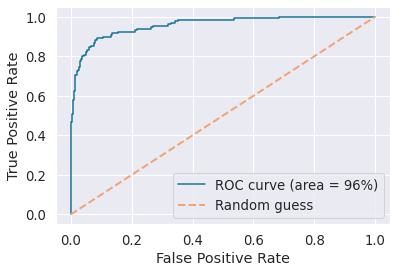

In [62]:
# Use Scikit-learn's ROC Curve Utility to plot ROC curve. For reference, we also include a 'line of determination (y=x)',
# which represents no lift from the model (just random guessing, the worst kind of model performance).
# Our goal is to produce a model that separates from the line of determination and captures as much of the area above the line
# as possible. 

sns.set_style('dark')
sns.set(font = 'sans-serif',font_scale = 1.2)
fpr, tpr, _ = roc_curve(validate['Attrition'],  y_pred)
fig = plt.figure()
# Create ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.0%})'.format(auc),color='#157394')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='#F4A374', label='Random guess')
# plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.grid()
plt.legend()

plt.show()


fig.set_size_inches(9,4,forward=True)
fig.savefig('temp.png', transparent=True)

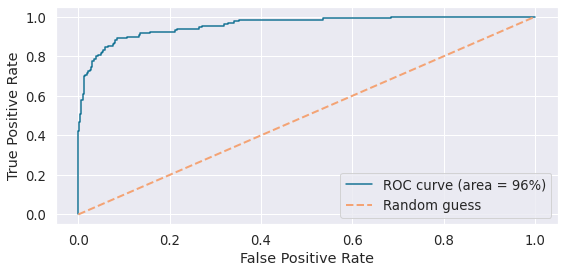

In [63]:
fig